In [1]:
import os
from pathlib import Path
import pyrootutils

notebook_path = Path(os.path.abspath(""))
pyrootutils.setup_root(notebook_path, indicator=".project-root", pythonpath=True)

DIRNAME = r"/cluster/home/vjimenez/adv_pa_new/results/dg/datashift"

In [2]:
from src.plot.dg import *
from src.plot.dg._retrieve import *
from src.plot.dg._plot import *

In [3]:
LIST_PASPECIFIC_METRICS = ["logPA", "beta", "acc_pa", "AFR_true", "AFR_pred", "CD", "MMD", "FID", "CS", "KL", "W", "oracle"]

def _get_metric_value(
        data,
        list_metric_indexes,
        metric_name,
        run_ind,
        env = 1
    ):
    pos_to_select = list_metric_indexes[env-1][run_ind]
    try:
        if metric_name in LIST_PASPECIFIC_METRICS:
            key_name = f"PA(0,{env})/{metric_name}"
            if metric_name == "oracle":
                key_name = f"oracle/acc_{env-1}"
                
            out = data[key_name][run_ind][pos_to_select].item()
        else:
            out = data[f"{metric_name}"][run_ind][pos_to_select].item()
    except:
        import ipdb; ipdb.set_trace()
    return out

# Apply selection functions to the metric:
def _fun_selection_metric(metric_array, selection_criterion) -> int:
    if selection_criterion == "min":
        return np.argmin(metric_array).item()
    elif selection_criterion == "max":
        return np.argmax(metric_array).item()
    elif selection_criterion == "first":
        return 0
    else:
        return -1

def _generate_indexes(
        data,
        selection_metric,
        selection_criterion,
        selection_environment = None
    ):
    run_names = list(data.keys())
    num_runs = len(data[run_names[0]])

    # Environments to select from:
    envs_to_select = [selection_environment]*5
    if selection_environment == None:
        envs_to_select = [i for i in range(1, 6)]

    # Select the metric indexes:
    datakey = lambda env: selection_metric
    if selection_metric in LIST_PASPECIFIC_METRICS:
        datakey = lambda env: f"PA(0,{env})/{selection_metric}"
        if selection_metric == "oracle":
            datakey = lambda env: f"oracle/acc_{env-1}"

    try:
        list_metric_indexes = [
            [
                _fun_selection_metric(
                    data[datakey(env)][i],
                    selection_criterion
                )
                for i in range(num_runs)
            ]
            for env in envs_to_select
        ]
    except:
        import ipdb; ipdb.set_trace()
    return list_metric_indexes

In [4]:
def plot_dg_nsf(
        data: dict,
        metric: str,
        selection_metric: str,
        selection_criterion: str,
        savedir: str,
        selection_environment: Optional[int] = None,
        selection_index: Optional[int] = None,
        yscale: Optional[bool] = "symlog",
        legend: Optional[bool] = True,
        save: Optional[bool] = False,
    ) -> None:
    """
        Args:
            data (dict): Dictionary with all the data for the desired runs.
            metric (str): Name of the metric to plot.
            selection_metric (str): Name of the metric that guides the selection of the `metric` values to plot.
            selection_criterion (str): Criterion of the `selection_metric`. Accepts "min", "max", "first" and "last".
            selection_environment (Optional[int]): Environment to implement the selection criterion. If None, it will be implemented
                for each environment separately.
    """
    assert selection_criterion in ["min", "max", "first", "last"], "Please specify an accepted selection criterion."

    # Number of runs:
    run_names = list(data.keys())
    num_runs = len(data[run_names[0]])            

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    # Get indexes from the metric of interest
    if selection_index == None:
        indexes_list = _generate_indexes(data, selection_metric, selection_criterion, selection_environment)
    else:
        list_envs = [i for i in range(1, 6)] if selection_environment==None else [selection_environment]
        indexes_list = [
            selection_index
            for run_ind in range(num_runs)
            for env in list_envs
        ]

    _get_value = functools.partial(_get_metric_value, data=data, list_metric_indexes=indexes_list)
    print(f"\nSelected indexes for each env: {indexes_list}\n")

    # Subset of the dictionary:
    dict_to_plot = {
        "num_factors": np.concatenate([
            np.arange(1, 6, dtype=int) for _ in range(num_runs)
        ]),
    }

    # List of environments:
    list_envs = [1]*5
    if metric in LIST_PASPECIFIC_METRICS:
        list_envs = [i for i in range(1, 6)]
    
    dict_to_plot.update(
        {   
            "model": [
                data["model"][run_ind]
                for run_ind in range(num_runs)
                for env in list_envs
            ],

            metric: np.concatenate([
                np.asarray([
                    _get_value(metric_name=metric, run_ind=run_ind, env=env)
                    for env in list_envs
                ])
            for run_ind in range(num_runs)
            ])
        }
    )
    level_set = pd.DataFrame(dict_to_plot)
    
    # Create a line plot
    _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    print(level_set)
    
    sns.lineplot(
        data=level_set,
        ax=ax,
        x="num_factors",
        y=metric,
        hue="model",
        style="model",
        palette=COLORS_DICT,
        dashes=False,
        marker="o",
        linewidth=3,
        legend=legend
    )

    ax.minorticks_on()
    ax.set_xticks([i for i in range(1,6)])

    ax.tick_params(axis="both", which="both", direction="in")
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--")

    # ax.set_ylim(0.945, 1.0)
        
    # posdiff = -(10**np.log10(abs(max(level_set[metric]))))/2
    # ax.set_ylim(min(level_set[metric])*2, posdiff)
    ax.set_xlabel("# Shift Factors", fontname=fontname)
    # r"$10^{-4} \times $ PA"
    ax.set_ylabel("Accuracy", fontname=fontname)
    ax.set_yscale(yscale) 
    
    # Legend
    if legend == True:
        handles, labels = ax.get_legend_handles_labels()
        labels = [LABELS_DICT[label] for label in labels]
        legend_properties = {
            "family": fontname,
            'size': 18
        }  
        ax.legend(
            handles,
            labels,
            # loc="best",
            loc="lower left",
            # fontsize=12,
            handlelength=0.5,
            prop=legend_properties
        )

    title = "Oracle @ max PA(0,1)"
    ax.set_title(title, fontname=fontname)
    plt.tight_layout()
    if save:
        plt.savefig(savedir)
        plt.clf()
        plt.close()
    else:
        plt.show()

In [6]:
data_dict = get_multiple_dict(
    dataset_names=["ZGO_hue_3"],
    run_names=[
        "erm",
        "irm",
        "lisa_08"
    ],
    datashift = True
)

Run:   0%|          | 0/3 [00:00<?, ?it/s]

Run: 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]


In [7]:
data_dict.keys()

dict_keys(['seed', 'dataset', 'model', 'trainer', 'epochs', 'n_classes', 'batch_size', 'net', 'pretrained', 'loss', 'optimizer', 'scheduler', 'MSE', 'PA(0,1)/logPA', 'PA(0,1)/beta', 'PA(0,1)/acc_pa', 'PA(0,1)/AFR_true', 'PA(0,1)/AFR_pred', 'PA(0,1)/CD', 'PA(0,1)/MMD', 'PA(0,1)/FID', 'PA(0,1)/CS', 'PA(0,1)/KL', 'PA(0,1)/W', 'PA(0,1)/oracle', 'PA(0,2)/logPA', 'PA(0,2)/beta', 'PA(0,2)/acc_pa', 'PA(0,2)/AFR_true', 'PA(0,2)/AFR_pred', 'PA(0,2)/CD', 'PA(0,2)/MMD', 'PA(0,2)/FID', 'PA(0,2)/CS', 'PA(0,2)/KL', 'PA(0,2)/W', 'PA(0,2)/oracle', 'PA(0,3)/logPA', 'PA(0,3)/beta', 'PA(0,3)/acc_pa', 'PA(0,3)/AFR_true', 'PA(0,3)/AFR_pred', 'PA(0,3)/CD', 'PA(0,3)/MMD', 'PA(0,3)/FID', 'PA(0,3)/CS', 'PA(0,3)/KL', 'PA(0,3)/W', 'PA(0,3)/oracle', 'PA(0,4)/logPA', 'PA(0,4)/beta', 'PA(0,4)/acc_pa', 'PA(0,4)/AFR_true', 'PA(0,4)/AFR_pred', 'PA(0,4)/CD', 'PA(0,4)/MMD', 'PA(0,4)/FID', 'PA(0,4)/CS', 'PA(0,4)/KL', 'PA(0,4)/W', 'PA(0,4)/oracle', 'PA(0,5)/logPA', 'PA(0,5)/beta', 'PA(0,5)/acc_pa', 'PA(0,5)/AFR_true', 'PA(


Selected indexes for each env: [[98, 98, 97], [98, 98, 97], [98, 98, 97], [98, 98, 97], [98, 98, 97]]

    num_factors model        logPA
0             1   ERM -3291.498535
1             2   ERM -3286.101562
2             3   ERM -3335.579102
3             4   ERM -3314.428467
4             5   ERM -3314.968018
5             1   IRM -3289.332275
6             2   IRM -3279.844238
7             3   IRM -3343.669189
8             4   IRM -3336.705566
9             5   IRM -3338.231445
10            1  LISA -3205.386230
11            2  LISA -3199.255615
12            3  LISA -3402.080322
13            4  LISA -3378.839844
14            5  LISA -3381.080322


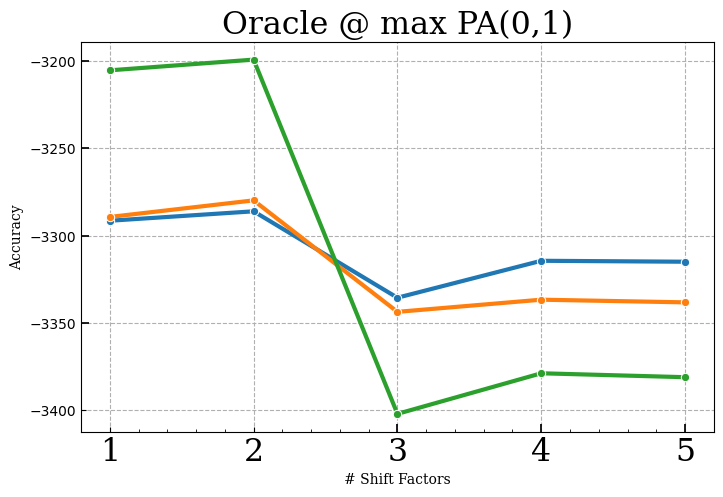

In [8]:
plot_dg_nsf(
        data = data_dict,
        metric = "logPA",
        selection_metric = "val/acc",
        selection_criterion = "max",
        selection_environment = 1,
        selection_index = None,
        yscale = "linear",
        legend = False,
        savedir=r"/cluster/home/vjimenez/adv_pa_new/results/dg/datashift/paper/selection_maxPA_0&1.png",
        save = False
)

# GET MODEL SELECTION TABLES

In [21]:
def model_selection_table(data: dict):
    
    metric = "oracle"
    metric_column_name = data_dict['dataset'][0]
    selection_metric = "logPA"
    selection_criterion = "max"
    selection_environment = 1
    selection_index = None

    for selection_metric in ["val/acc", "logPA", "AFR_pred"]:
        # Number of runs:
        run_names = list(data.keys())
        num_runs = len(data[run_names[0]])            

        indexes_list = _generate_indexes(data, selection_metric, selection_criterion, selection_environment)
        indexes_list = [indexes_list[0]] + indexes_list


        def _get_value(
                metric_name,
                run_ind,
                env = 1
            ):
            pos_to_select = indexes_list[env][run_ind]
            key_name = f"oracle/acc_{env}"
            try:
                out = data[key_name][run_ind][pos_to_select].item()
            except:
                import ipdb; ipdb.set_trace()
            return out

        print(f"\nSelected indexes for each env: {indexes_list}\n")

        # Subset of the dictionary:
        dict_to_plot = {
            "shift": np.concatenate([
                np.arange(0, 6, dtype=int) for _ in range(num_runs)
            ]),
        }

        list_envs = [i for i in range(6)]
        dict_to_plot.update(
            {   
                "model": [
                    data["model"][run_ind].lower()
                    for run_ind in range(num_runs)
                    for env in list_envs
                ],

                metric_column_name: np.concatenate([
                    np.asarray([
                        _get_value(metric_name=metric, run_ind=run_ind, env=env)
                        for env in list_envs
                    ])
                for run_ind in range(num_runs)
                ])
            }
        )

        if selection_metric == "val/acc":
            val_df = pd.DataFrame(dict_to_plot)
            val_df["metric"] = "acc"

            print("\n VAL DF", val_df.columns)

        else:
            other_df = pd.DataFrame(dict_to_plot)
            other_df["diff"] = other_df[metric_column_name] - val_df[metric_column_name] 
            other_df = other_df.drop(metric_column_name, axis=1)
            other_df = other_df.rename(columns={'diff': metric_column_name})
            other_df["metric"] = "pa" if selection_metric == "logPA" else "afrp"

            print("\n OTHER DF", other_df.columns)

            val_df = pd.concat([val_df, other_df], ignore_index=True)
            
    return val_df.sort_values(by=['model', 'shift', 'metric'])        

In [22]:
data_dict = get_multiple_dict(
        dataset_names=["CGO_1_pos"],
        run_names=[
            "erm",
            "irm",
            "erm_001",
            "irm_001",
        ],
        datashift = True
    )

val_df = model_selection_table(data_dict)

Run: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]



Selected indexes for each env: [[60, 65, 21, 16], [60, 65, 21, 16], [60, 65, 21, 16], [60, 65, 21, 16], [60, 65, 21, 16], [60, 65, 21, 16]]

> /tmp/ipykernel_3295470/4002374277.py(30)_get_value()
     29                 import ipdb; ipdb.set_trace()
---> 30             return out
     31 

oracle
*** SyntaxError: unexpected EOF while parsing
oracle/acc_0
60
0
0
[]
dict_keys(['seed', 'dataset', 'model', 'trainer', 'epochs', 'n_classes', 'batch_size', 'net', 'pretrained', 'loss', 'optimizer', 'scheduler', 'MSE', 'PA(0,1)/logPA', 'PA(0,1)/beta', 'PA(0,1)/acc_pa', 'PA(0,1)/AFR_true', 'PA(0,1)/AFR_pred', 'PA(0,1)/CD', 'PA(0,1)/MMD', 'PA(0,1)/FID', 'PA(0,1)/CS', 'PA(0,1)/KL', 'PA(0,1)/W', 'PA(0,1)/oracle', 'PA(0,2)/logPA', 'PA(0,2)/beta', 'PA(0,2)/acc_pa', 'PA(0,2)/AFR_true', 'PA(0,2)/AFR_pred', 'PA(0,2)/CD', 'PA(0,2)/MMD', 'PA(0,2)/FID', 'PA(0,2)/CS', 'PA(0,2)/KL', 'PA(0,2)/W', 'PA(0,2)/oracle', 'PA(0,3)/logPA', 'PA(0,3)/beta', 'PA(0,3)/acc_pa', 'PA(0,3)/AFR_true', 'PA(0,3)/AFR_pred', 'PA(

# EN MASSA

In [7]:
DATASET_DICT = {
    "ZSO_hue_3": "ZSO",
    "ZGO_hue_3": "ZGO",
    "CGO_1_hue": "1-CGO",
    "CGO_2_hue": "2-CGO",
    "CGO_3_hue": "3-CGO"
}

FACTOR_DICT = {
    "pos": r"\texttt{position}",
    "hue": r"\texttt{hue}"
}

MODEL_NAMES = {
    "erm": r"{\color{tab:blue} \textbf{ERM}}",
    "irm": r"{\color{tab:orange} \textbf{IRM}}",
    "lisa": r"{\color{tab:green} \textbf{LISA}}"
}


def dataset_name_parser(ds_name: str):
    return f"{DATASET_DICT[ds_name]}"

In [8]:
def generate_latex_table(df, optimizer: str, lr: float, main_factor: str, n_pair: bool):
    # Get the dataset names (e.g., pos_zero_npair, pos_idval_npair, etc.)
    dataset_names = df.columns[2:-1].unique()
    dataset_names_parsed = [dataset_name_parser(ds_name) for ds_name in dataset_names]
    # Get the model names (e.g., erm, irm, etc.)
    model_names = df['model'].unique()
    model_names_parsed = [MODEL_NAMES[model_name] for model_name in model_names]

    # Variable to track if significant improvement was observed in AFR$_P$
    significant_improvement_observed = False
    
    # Start building the LaTeX table
    latex_code = "\\begin{table}[H]\n\\centering\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{l|cl|cl|cl|cl|cl|cl}\n"

    # Header for shift values
    text_shift = f"Test \#{shift}"
    latex_code += "\\multirow{2}{*}{} & " + " & ".join(
        [
        f"\\multicolumn{{2}}{{c|}}{{\\textbf{{{text_shift}}}}}" if shift < 5 else f"\\multicolumn{{2}}{{c}}{{\\textbf{{{text_shift}}}}}"
        for shift in range(6)
    ]
    ) + " \\\\\n"

    # # Select the indexes of the best accuracies:    
    # list_max_acc, list_max_pa = [], []
    # for model in model_names:
    #     accs_dataset = np.zeros((len(dataset_names), 6))
    #     for idataset, dataset in enumerate(dataset_names):
    #         for shift in range(6):
    #             row = df[(df['shift'] == shift) & (df['model'] == model)]
    #             if not row.empty:
    #                 acc =  100.0*row[dataset][row['metric'] == 'acc'].values[0]
    #             else:
    #                 acc= 0.0
    #             accs_dataset[idataset, shift] = acc
    #     list_max_acc.append(np.argmax(accs_dataset, axis=0))
    
    
    # Iterate over each model
    for imodel, (model, model_parsed) in enumerate(zip(model_names, model_names_parsed)):
        # Header for metrics (Acc., PA)
        latex_code += f"Test \\textbf{{{model_parsed}}} & " + " & ".join(
            # [r"\textbf{Acc.} & \textbf{PA}" for _ in range(6)]
            [r"Acc. & $\Delta_{\operatorname{PA}}$" for _ in range(6)]
        ) + " \\\\\n"
        latex_code += "\\midrule\n"

        # Iterate over each dataset
        for idataset, (dataset, dataset_parsed) in enumerate(zip(dataset_names, dataset_names_parsed)):
            latex_code += f"{dataset_parsed}"
            # latex_code += f"\\textbf{{{dataset_parsed}}}"
            for shift in range(6):
                # Filter the DataFrame for the current dataset, model, and shift
                row = df[(df['shift'] == shift) & (df['model'] == model)]
                if not row.empty:
                    # Extract the metric values for the current dataset, model, and shift
                    acc = 100.0*row[dataset][row['metric'] == 'acc'].values[0]
                    pa = 100.0*row[dataset][row['metric'] == 'pa'].values[0]

                    # Replace 0.000 with a dash "-"
                    # acc_str = f"\\textbf{{{acc:.1f}}}" if idataset == list_max_acc[imodel][shift] else f"{acc:.1f}"
                    acc_str = f"{acc:.1f}"
                    if float(f"{pa:.1f}") > 0:
                        pa_str_in = f"\Plus {abs(pa):.1f}"
                        pa_str = f"{{\\color{{tab:green}}  \\textbf{{{pa_str_in}}}}}"
                    elif float(f"{pa:.1f}") < 0:
                        pa_str_in = f"\Minus {abs(pa):.1f}"
                        pa_str = f"{{\\color{{tab:red}} \\textbf{{{pa_str_in}}}}}"
                    else:
                        pa_str = r"\PlusMinus 0.01" #"0.0"
                    
                    latex_code += f" & {acc_str} & {pa_str}"
                else:
                    latex_code += " & - & -"  # Placeholder if there's no data
            latex_code += " \\\\\n"


        if imodel < len(model_names)-1:
            latex_code += "\\midrule\n\\addlinespace\n\\addlinespace\n"
    
    latex_code += "\\bottomrule\n\\end{tabular}%\n}\n"

    # Add caption with significant improvement information
    caption_text = f"REMOVEopt={optimizer}-lr={lr}-mf={main_factor}-npair={n_pair}REMOVE Test performance on increasingly shifted datasets for models selected during ERM and IRM procedures. Different validation datasets are used, and the selection capabilities of PA and validation accuracy are compared."
    latex_code += f"\\caption{{{caption_text}}}\n\\label{{tab:label}}\n\\end" + "{" + "table}"
    
    return latex_code

In [23]:
# TRYING INDIVIDUALLY TO SEE IF IT WORKS:

ds_name = "ZGO_hue_3"
data_dict = get_multiple_dict(
        dataset_names=[ds_name],
        run_names=[
            "erm_0001",
            "irm_0001",
            "erm_adam_001",
            "irm_adam_001",
        ],
        datashift = True
    )

Run: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s]


In [25]:
data_dict

defaultdict(list,
            {'seed': [0, 0, 0, 0],
             'dataset': ['ZGO_hue_3', 'ZGO_hue_3', 'ZGO_hue_3', 'ZGO_hue_3'],
             'model': ['ERM', 'IRM', 'ERM', 'IRM'],
             'trainer': ['ddp', 'ddp', 'ddp', 'ddp'],
             'epochs': [100, 100, 100, 100],
             'n_classes': [3, 3, 3, 3],
             'batch_size': ['${diagvib_dataset.batch_size}',
              '${diagvib_dataset.batch_size}',
              '${diagvib_dataset.batch_size}',
              '${diagvib_dataset.batch_size}'],
             'net': ['resnet18', 'resnet18', 'resnet18', 'resnet18'],
             'pretrained': [False, False, False, False],
             'loss': ['CrossEntropyLoss',
              'CrossEntropyLoss',
              'CrossEntropyLoss',
              'CrossEntropyLoss'],
             'optimizer': [None, None, None, None],
             'scheduler': [None, None, None, None],
             'MSE': [array([], dtype=float64),
              array([], dtype=float64),
            

In [20]:
df_results = model_selection_table(data_dict)


Selected indexes for each env: [[0, 4, 4, 5], [0, 4, 4, 5], [0, 4, 4, 5], [0, 4, 4, 5], [0, 4, 4, 5], [0, 4, 4, 5]]



IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
%%capture
dataset_name_list = ["ZGO_hue_3", "CGO_1_hue", "CGO_2_hue", "CGO_3_hue", "ZSO_hue_3"]
for ids, ds_name in enumerate(dataset_name_list):
    data_dict = get_multiple_dict(
        dataset_names=[ds_name],
        run_names=[
            "erm_0001",
            "irm_0001",
            "erm_adam_001",
            "irm_adam_001",
        ],
        datashift = True
    )
    import ipdb; ipdb.set_trace()
    df_results = model_selection_table(data_dict)
    if ids == 0:
        merged_df = df_results.copy()

    else:
        merged_df = pd.merge(merged_df, df_results, on=['shift', 'model', 'metric'])

merged_df = merged_df[
    ["shift", "metric"] + dataset_name_list + ["model"]
]

In [76]:
latex_code = generate_latex_table(merged_df, optimizer = 'sgd', lr=0.0001, main_factor='hue', n_pair=False)

In [77]:
print(latex_code)

\begin{table}[H]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{l|cl|cl|cl|cl|cl|cl}
\multirow{2}{*}{} & \multicolumn{2}{c|}{\textbf{0}} & \multicolumn{2}{c|}{\textbf{1}} & \multicolumn{2}{c|}{\textbf{2}} & \multicolumn{2}{c|}{\textbf{3}} & \multicolumn{2}{c|}{\textbf{4}} & \multicolumn{2}{c}{\textbf{5}} \\
\textbf{{\color{tab:blue} \textbf{ERM}}} & Acc. & $\Delta_{\operatorname{PA}}$ & Acc. & $\Delta_{\operatorname{PA}}$ & Acc. & $\Delta_{\operatorname{PA}}$ & Acc. & $\Delta_{\operatorname{PA}}$ & Acc. & $\Delta_{\operatorname{PA}}$ & Acc. & $\Delta_{\operatorname{PA}}$ \\
\midrule
ZGO & 99.9 & {\color{tab:red} \textbf{\Minus 45.6}} & 30.4 & {\color{tab:green}  \textbf{\Plus 4.0}} & 33.3 & {\color{tab:green}  \textbf{\Plus 2.4}} & 28.8 & {\color{tab:red} \textbf{\Minus 0.3}} & 33.6 & {\color{tab:red} \textbf{\Minus 0.3}} & 33.4 & {\color{tab:green}  \textbf{\Plus 1.4}} \\
1-CGO & 99.4 & {\color{tab:red} \textbf{\Minus 51.8}} & 23.5 & {\color{tab:green}  \textbf{\Plus 5.1}} & 2